# Fire Predictions From CNN

Loads a CNN model from S3, applies raw input data to the model, and makes predictions. Recursively makes predictions for a user specified number of days.

In [22]:
# Load packages
import boto3
import datetime
import io
import itertools
import keras
import numpy as np
import os
import pandas as pd
import pickle
import rasterio as rio
import requests
from matplotlib import pyplot as plt

In [23]:
# s3 config
s3_client = boto3.client('s3')
bucket_name = 'hotzone'

## Load Model from S3

In [24]:
def pull_data_from_s3(s3_client, bucket_name, key_name):
    '''
    Pulls pre-processed data from S3.

    Args:
        - s3_client: boto3 s3 client
        - bucket_name: name of bucket on s3 to pull data from
        - key_name: directory/file_name to pull data from
    Returns:
        - Nothing
    
    https://stackoverflow.com/questions/48049557/how-to-write-npy-file-to-s3-directly
    '''
    
    array_data = io.BytesIO()
    s3_client.download_fileobj(bucket_name, key_name, array_data)
    
    array_data.seek(0)
    array = pickle.load(array_data)

    return array

In [37]:
# load model from s3
new_config = pull_data_from_s3(s3_client, bucket_name, 'models/model_config.pickle')
new_weights = pull_data_from_s3(s3_client, bucket_name, 'models/model_weights.pickle')

model = keras.Model.from_config(new_config)
model.set_weights(new_weights)

## Make Predictions

In [26]:
# these are just some dummy lat/long coordinates i made

lat_long_coords = [
    (-121.9230432, 36.52439536),
    (-121.8955554, 36.52439536),
    (-121.9276244, 36.52071369),
    (-121.8863929, 36.52071369),
    (-121.9276244, 36.51703184),
    (-121.8863929, 36.51703184),
    (-121.9322057, 36.51334982),
    (-121.872649, 36.51334982),
    (-121.9322057, 36.50966762),
    (-121.872649, 36.50966762),
    (-121.9322057, 36.50598525),
    (-121.8680677, 36.50598525),
    (-121.9322057, 36.5023027),
    (-121.8680677, 36.5023027),
    (-121.936787, 36.49861998),
    (-121.8680677, 36.49861998),
    (-121.936787, 36.49493708),
    (-121.8680677, 36.49493708),
    (-121.9322057, 36.49125401),
    (-121.8680677, 36.49125401),
    (-121.9322057, 36.48757076),
    (-121.8680677, 36.48757076),
    (-121.9322057, 36.48388734),
    (-121.8589052, 36.48388734),
    (-121.9322057, 36.48020374),
    (-121.8680677, 36.48020374),
    (-121.9322057, 36.47651996),
    (-121.8589052, 36.47651996),
    (-121.9322057, 36.47283602),
    (-121.8543239, 36.47283602),
    (-121.9322057, 36.46915189),
    (-121.8222549, 36.46915189),
    (-121.9322057, 36.46546759),
    (-121.8130923, 36.46546759),
    (-121.9276244, 36.46178312),
    (-121.808511, 36.46178312),
    (-121.9322057, 36.45809847),
    (-121.808511, 36.45809847),
    (-121.9322057, 36.45441365),
    (-121.8039297, 36.45441365),
    (-121.936787, 36.45072865),
    (-121.7947672, 36.45072865),
    (-121.9505309, 36.44704347),
    (-121.8955554, 36.44704347),
    (-121.8909742, 36.44704347),
    (-121.8863929, 36.44704347),
    (-121.8818116, 36.44704347),
    (-121.7947672, 36.44704347),
    (-121.9505309, 36.44335812),
    (-121.8863929, 36.44335812),
    (-121.8818116, 36.44335812),
    (-121.7901859, 36.44335812),
    (-121.9505309, 36.4396726),
    (-121.8955554, 36.4396726),
    (-121.8818116, 36.4396726),
    (-121.7901859, 36.4396726),
    (-121.9505309, 36.4359869),
    (-121.7856046, 36.4359869),
    (-121.9505309, 36.43230103),
    (-121.7856046, 36.43230103),
    (-121.9505309, 36.42861498),
    (-121.7810233, 36.42861498),
    (-121.9505309, 36.42492875),
    (-121.8955554, 36.42492875),
    (-121.872649, 36.42492875),
    (-121.7810233, 36.42492875),
    (-121.9505309, 36.42124235),
    (-121.8955554, 36.42124235),
    (-121.872649, 36.42124235),
    (-121.776442, 36.42124235),
    (-121.9505309, 36.41755578),
    (-121.8955554, 36.41755578),
    (-121.872649, 36.41755578),
    (-121.776442, 36.41755578),
    (-121.9413683, 36.41386903),
    (-121.9001367, 36.41386903),
    (-121.8634864, 36.41386903),
    (-121.776442, 36.41386903),
    (-121.9322057, 36.4101821),
    (-121.904718, 36.4101821),
    (-121.8634864, 36.4101821),
    (-121.776442, 36.4101821),
    (-121.9322057, 36.406495),
    (-121.9092993, 36.406495),
    (-121.8634864, 36.406495),
    (-121.776442, 36.406495),
    (-121.9322057, 36.40280773),
    (-121.9092993, 36.40280773),
    (-121.8634864, 36.40280773),
    (-121.776442, 36.40280773),
    (-121.9230432, 36.39912028),
    (-121.9184619, 36.39912028),
    (-121.8634864, 36.39912028),
    (-121.776442, 36.39912028),
    (-121.8634864, 36.39543265),
    (-121.776442, 36.39543265),
    (-121.8634864, 36.39174486),
    (-121.7810233, 36.39174486),
    (-121.8634864, 36.38805688),
    (-121.7810233, 36.38805688),
    (-121.8634864, 36.38436873),
    (-121.7856046, 36.38436873),
    (-121.8634864, 36.38068041),
    (-121.7901859, 36.38068041),
    (-121.8589052, 36.37699191),
    (-121.7947672, 36.37699191),
    (-121.8589052, 36.37330323),
    (-121.7947672, 36.37330323),
    (-121.8589052, 36.36961439),
    (-121.7993485, 36.36961439),
    (-121.8589052, 36.36592536),
    (-121.7993485, 36.36592536),
    (-121.8497426, 36.36223616),
    (-121.8130923, 36.36223616),
    (-121.8314174, 36.35854679),
    (-121.8268362, 36.35854679),
    (-121.9230432, 36.52439536)
]

In [27]:
def get_index(long,lat):
    
    '''
    Get the pixel of a given coordinate.
    
    Args:
        - Long: longitude of point
        - Lat: latitude of point
    Returns:
        - pixelrow: index of row of point
        - pixelcol: index of column of point
    
    '''

    left = -123.50294421461426
    top = 39.00106654811723

    xres = 0.004411751262768785
    yres = -0.0041759449407971815
    
    pixelcol = int(np.rint((long - left)/xres))
    pixelrow = int(np.rint((lat - top)/yres))
    
    return (pixelrow, pixelcol)

In [28]:
def get_coords(y, x):
    
    '''
    Get the coordinates of a given pixel in the tif coordinate system.
    
    Args:
        - Y: index of row of point
        - X: index of column of point
    Returns:
        - Long: longitude of point
        - Lat: latitude of point
    '''
    
    left = -123.50294421461426
    top = 39.00106654811723

    xres = 0.004411751262768785
    yres = -0.0041759449407971815

    deltax = xres*x
    deltay = yres*y

    long = left+deltax
    lat = top+deltay
    
    return (long, lat)

In [29]:
def get_weather(max_values, lat, long, day):

    '''
    Get tomorrow's weather forecast for fire prediction.
    
    Args:
        - Max_values: list of weather max_values used to scale weather
        - Lat: latitude of point to fetch weather for
        - Long: longitude of point to fetch weather for
    Returns:
        - weather: a list of weather data to use for prediction
    '''
    
    
    s = requests.Session()
    s.auth = ('user', 'pass')
    s.headers.update({'Accept-Encoding':'gzip'})
    headers = {'Accept-Encoding':'gzip'}
    
    key = '5ffac5f056d341c6296cba58fa96e9ba'
    date = str(datetime.date.today() + datetime.timedelta(days = day)) + 'T12:00:00'
    lat = str(lat,)
    long = str(long)
    blocks = '[currently,minutely,hourly,alerts]'
    units = 'ca'

    # set the query string for darksky
    query = ('https://api.darksky.net/forecast/'+key+'/'+ 
    lat+','+long+','+date+'?exclude=' 
    +blocks+'&units='+units)

    # Make the call to Dark Sky to get all the data for that date and location
    r = s.get(query,headers=headers)

    data = r.json()
    data = data['daily']['data'][0]
    
    rainint = data['precipIntensityMax']
    high_t = data['temperatureHigh']
    low_t= data['temperatureLow']
    humidity = data['humidity']
    wind_speed = data['windSpeed']
    wind_direction = data['windBearing']
    
    weather_data = {
        'rainint': rainint,
        'High T': high_t,
        'Low T': low_t,
        'Humidity': humidity,
        'Wind Speed': wind_speed,
        'Wind Direction': wind_direction
    }
    
    weather = []
        
    for k, v in weather_data.items():
        max_val = max_values.get(k, 1)
        
        if k in ['High T', 'Low T']:
            v += 273.15
        else:
            v
        
        val = v/float(max_val)
        weather.append(val)
          
    return weather

In [30]:
def pull_weather_maxes_from_s3():
    '''
    Pull files from S3 for the provided year and save to local directory
    '''
    
        
    s3 = boto3.resource('s3')
    
    key = "BayAreaWeather/max_values/max_values.pickle"
    directory = '/home/ubuntu/wildfireplus/weather_max/'
    path = directory + 'max_values.pickle'
    
    s3.Bucket('hotzone').download_file(key, path)
    
    total_path = os.path.abspath(directory)
    
    for f in os.listdir(total_path):
        if f.endswith('.pickle'):
            max_values = total_path + '/' + f

    max_values = pd.read_pickle(max_values)
    
    return max_values

In [34]:
def predict_day(lat_long_coords, day=1):

    '''
    Predict where fire will be in the next day.
    
    Args:
        - lat_long_coords: a list of lat/long coordinates that make up a polygon representing where fire is
    Returns:
        - prediction: a list of lat/long coordinates that make up a polygon representing where fire will be
    '''
    
    today = np.zeros((719, 908))
    side = 16
        
    for (long, lat) in lat_long_coords:
        index = get_index(long,lat)
        today[index] = 1
        
    np.pad(today, pad_width=32, mode='constant', constant_values=0)
    
    fire_vals = np.where(today == 1)
    
    x_avg = int(np.mean(fire_vals[0]))
    y_avg = int(np.mean(fire_vals[1]))

    # minimize computations by only making predictions for pixels in 50x50 square around pixel of interest
    x_min = x_avg - 50
    x_max = x_avg + 50
    
    x_min = max(x_min, 0)
    x_max = min(x_max, 972)
    
    y_min = y_avg - 50
    y_max = y_avg + 50
    
    y_min = max(y_min, 0)
    y_max = min(y_max, 783)
    
    
    x_vals = range(x_min, x_max)
    y_vals = range(y_min, y_max)
    
    vals = list(itertools.product(x_vals, y_vals))
    
    values = []
    
    shape = today.shape
    prediction = np.zeros(shape)
    
    (long, lat) = get_coords(x_avg, y_avg)
    
    # get max weather values
    max_values = pull_weather_maxes_from_s3()
    
    weather = get_weather(max_values, lat, long, day)
    
    for (xi, yi) in vals:
        
        point = (xi, yi)

        xi_r = int(xi + side)
        xi_l = int(xi - side)
        yi_b = int(yi + side)
        yi_t = int(yi - side)
        
        if xi_r > 0 and xi_l > 0 and yi_b > 0 and yi_t > 0:

            m = today[xi_l:xi_r, yi_t:yi_b]

            if (m.shape == (32, 32)):
                fire = []
                w = []

                fire.append(np.asarray(m))
                w.append(np.asarray(weather))
                
                fire = np.asarray(fire)
                w = np.asarray(w)
            
                obs = len(fire)
                fire = fire.reshape(obs, 32, 32, 1)

                val = model.predict([fire, w])

                prediction[point] = val
    
    # create outline of prediction
    prediction = np.where(prediction < .999, 0, 1)
    
    outline = np.rint(prediction)
    outline = np.diff(outline, prepend = 0)
    outline = np.abs(outline)
    
    # get pixels from outline
    poly_to_plot = np.where(outline != 0)
    
    # instantiate a matrix in the target shape
    shape = outline.shape
    poly = np.zeros(shape)

    # create a list of coordinates in the tif coordinate system
    tif_coordinates = []

    for (xi, yi) in list(zip(poly_to_plot[0], poly_to_plot[1])):
        poly[xi,yi] = 1
        coords = get_coords(xi, yi)
        tif_coordinates.append(coords)

    return tif_coordinates

CPU times: user 50.6 s, sys: 54.3 s, total: 1min 44s
Wall time: 53.9 s


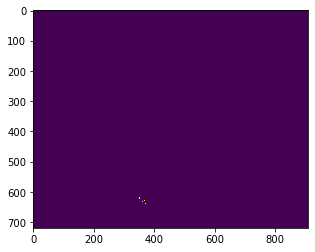

In [35]:
%%time

# predict fire for tomorrow
tif_coordinates_tomorrow = predict_day(lat_long_coords, 1)

CPU times: user 55.3 s, sys: 1min 1s, total: 1min 57s
Wall time: 58.3 s


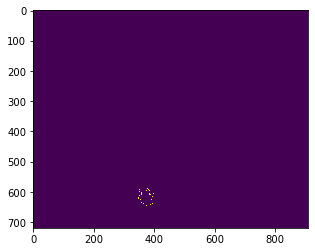

In [36]:
%%time

# predict fire in two days
tif_coordinates_two_days = predict_day(tif_coordinates_tomorrow, 2)